# Workflow Model 1

## Import dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [2]:

DATASET_URI="/kaggle/input/animals10/raw-img"


In [ ]:
# from dotenv import dotenv_values
# from dotenv import dotenv_values

# Retrieve dotenv config
# config = dotenv_values(".env")

# Retrieve DATASET_URI
# DATASET_URI=config["DATASET_URI"]

## Pre-processing

### Imports

In [3]:
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import keras

from keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D, Rescaling
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import data as tf_data


### Data conversion

Define parameters

In [4]:
# Define the parameters.

random.seed(1337)
batch_size = 128 # TODO : increase batch size
image_size = (180, 180)
seed = random.randint(1, 200)

In [5]:


# We then import the dataset from directory and store the data in train and test.

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1, # TODO : 0.1
  subset="training",
  seed=seed,
  image_size=image_size,
  batch_size=batch_size,
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=image_size,
  batch_size=batch_size
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


### Data visualisation

#### Shape

The results below tell us that :

- The image_batch is a tensor of the shape (32, 180, 180, 3).
- This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [6]:
# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

Shape of the training set images => (128, 180, 180, 3)
Shape of the training set labels => (128,)
Shape of the testing set images => (128, 180, 180, 3)
Shape of the testing set labels => (128,)


#### Pre-visualization

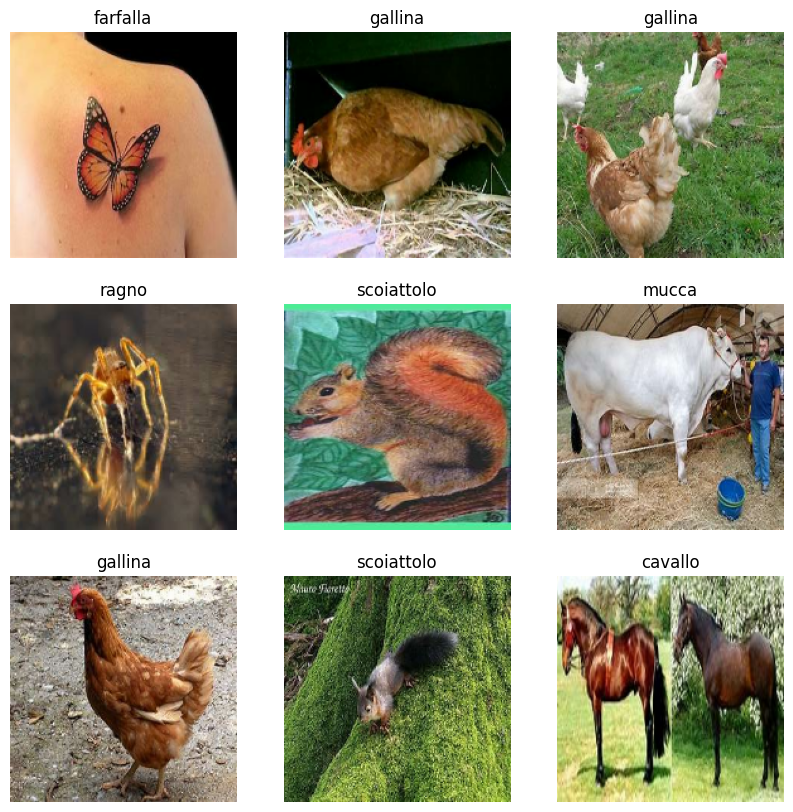

In [7]:
# Print a summary of the image classes with an image of each class.
# We will extract 1 image of the training set.

plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model training

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Because we are working with images, the images are in the [0, 255] range.
- We therefore want to normalize the data to values from [0, 1].
- That way, the model will be more pertinent.


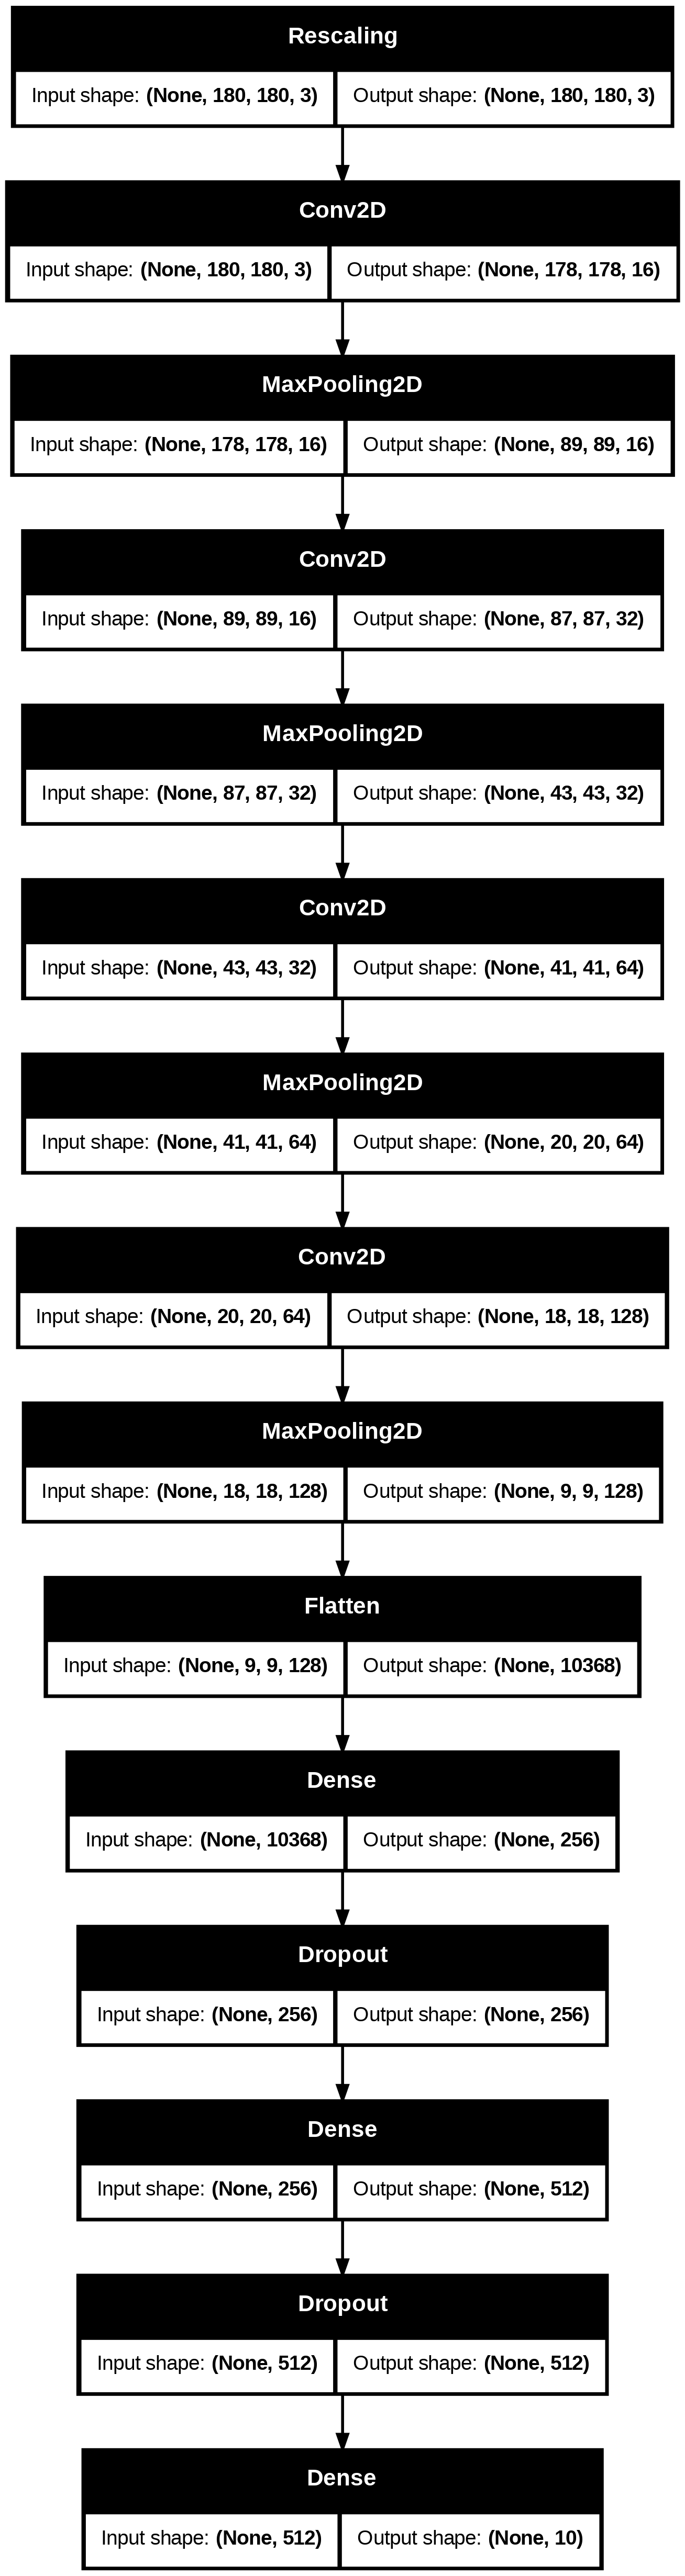

In [14]:
num_classes = len(class_names)


# Model creation
model_2 = Sequential([
     # defines input shape
    Input(shape = (180,180, 3)),
    # homogeneus range
    Rescaling(1./255),


    # filters and scans image to detect local patterns:
    # # 16: nº of filters: each filter captures a different characteristic
    # # (3,3): filter size:  analizes small zones
    # # relu: activation function that eliminates negative values -> adds non linearity
    Conv2D(16, (3, 3), activation = "relu"),
    # redueix la mida de la imatge (downsampling)
    # in each 2,2 block takes only the maximum value
    # like zoom out i quedar-se amb lo mes rellevant
    MaxPooling2D(2, 2),

    # these are repeating several times:
    # we are incrementing filters everytime.
    # first layer: contorns, linies
    # medium layers: ull, pota
    # final layers: abstract forms (cat, dog)
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),


    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),


    Conv2D(128, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),

    # aplana la imatge a un vector 1d
    # passa de la part visual/convolucional  a la numerica (decisio)
    Flatten(),

    # *Funció: Capa totalment connectada. Cada neurona està connectada amb totes les de l’anterior.
    # 256 neurones.
    # ReLU com a activació per no-linealitat.
    # Són les capes "intel·lectuals" del model.
    # Combinen totes les característiques detectades per predir una classe
    Dense(256, activation = "relu"),

    # Funció: Durant l'entrenament, desactiva aleatòriament un % de neurones.
    # Això evita que el model memoritzi (overfitting).
    # Aquí: desactives el 20% de neurones aleatòriament cada cop
    Dropout(0.3),
    Dense(512, activation = "relu"),
    Dropout(0.3),
    # output Layer
    # Funció: Capa final de classificació.
    # num_classes: tantes neurones com categories (per exemple, 10 si tens 10 animals).
    # softmax: retorna probabilitats → la classe amb més probabilitat serà la predicció.
    # softmax transforma els valors numèrics en probabilitats que sumen 1.
    Dense(num_classes, activation = "softmax")

])
keras.utils.plot_model(model_2, show_shapes=True)


In [15]:
# Print the model summary
model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,888,618 (11.02 MB)

 Trainable params: 2,888,618 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [19]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CNN_Image_classification/m2_Mo_at_{epoch}.keras"), keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
model_2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
history_2 = model_2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
    batch_size=batch_size,
)

Epoch 1/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 182ms/step - accuracy: 0.2612 - loss: 2.0536 - val_accuracy: 0.4284 - val_loss: 1.6071
Epoch 2/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4782 - loss: 1.4933 - val_accuracy: 0.5709 - val_loss: 1.2904
Epoch 3/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5771 - loss: 1.2451 - val_accuracy: 0.5965 - val_loss: 1.2246
Epoch 4/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6362 - loss: 1.0809 - val_accuracy: 0.6183 - val_loss: 1.1672
Epoch 5/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6769 - loss: 0.9446 - val_accuracy: 0.6137 - val_loss: 1.1940
Epoch 6/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7146 - loss: 0.8474 - val_accuracy: 0.6404 - val_loss: 1.1237
Epoch 7/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7546 - loss: 0.7216 - val_accuracy: 0.6607 - val_loss: 1.1237
Epoch 8/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7886 - loss: 0.6169 - val_ac

## Model evaluation

### Retrieve the keys

In [20]:
print(history_2.history.keys())
print(history_2.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Print the graph

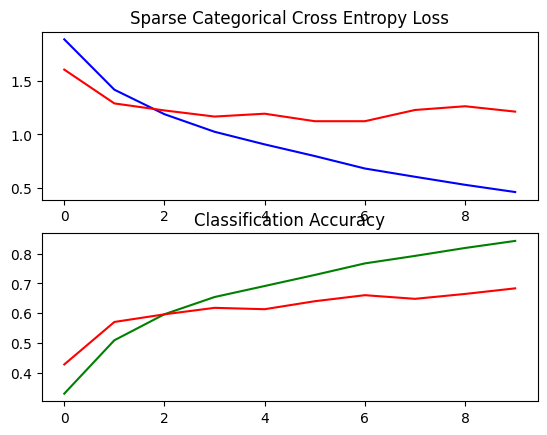

In [21]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(history_2.history['loss'], color='blue', label='train')
plt.plot(history_2.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history_2.history['accuracy'], color='green', label='train')
plt.plot(history_2.history['val_accuracy'], color='red', label='val')
plt.show()

### Evaluate the model

In [23]:
test_loss, test_acc = model_2.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6659 - loss: 1.1104
Test loss =>  1.123687744140625
Test accuracy =>  0.6606801748275757


### Test the predictions

In [25]:
import numpy as np
predictions = model_2.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
(2617, 10)


### Print confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

[[407   9   6   5  13  22   8   4  12   6]
 [ 60 152   4   1   2   3  16   7   2   6]
 [ 44   6  83   1   4   0   8  11   4   6]
 [ 13   2   0 179   7   7   0   0  18   3]
 [ 43   5   1   7 203  11   2   4   2   1]
 [ 74   0   2   4   2  65   0   2   6   8]
 [ 54  11  11   0   0   1  96  10   2   2]
 [ 44   7   7   3   2   4   8  86   1   8]
 [ 44   1   2  28   8  25   0   5 361  15]
 [ 45   1   4   4   4  14   0  11   8  97]]


Save the model

In [27]:
model_2.save("/content/drive/MyDrive/CNN_Image_classification/m1_Mo.keras")